# Classifying Images of Clothing

In this tutorial, we'll build and train a neural network to classify images of clothing, like sneakers and shirts.

It's okay if you don't understand everything. This is a fast-paced overview of a complete TensorFlow program, with explanations along the way. The goal is to get the general sense of a TensorFlow project, not to catch every detail.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

## Install and import dependencies

We'll need [TensorFlow Datasets](https://www.tensorflow.org/datasets/), an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with. We're also using a few helper libraries.

In [28]:
!pip install -U tensorflow_datasets

In [1]:
import tensorflow as tf

2023-02-27 22:10:04.484487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the Fashion MNIST dataset

In [4]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

2023-02-27 22:10:19.515355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [5]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [6]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [7]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()
train_dataset

<CacheDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

### Explore the processed data

Let's plot an image to see what it looks like.

In [8]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))


2023-02-27 22:10:53.499431: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-02-27 22:10:53.499745: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

In [14]:
BATCH_SIZE = 100
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

## Build the mechanized model

Building the neural network requires configuring the layers of the model, then compiling the model.

In [11]:


import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism

mechanized_model = MechanizedSequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])


## Choose mechanism and compile the model

In [12]:
mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_mechanism_para(sigma = 0.1)

mechanized_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              run_eagerly=True)
mechanized_model.summary()

Model: "mechanized_sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [15]:
gaussian_history = mechanized_model.fit(train_dataset, epochs=2, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
  1/600 [..............................] - ETA: 29:56 - loss: 2.4679 - accuracy: 0.0100In Gaussian Mechanism
Create Gaussian noise when accessing the training data
  2/600 [..............................] - ETA: 39s - loss: 2.3291 - accuracy: 0.1350  In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
  4/600 [..............................] - ETA: 26s - loss: 2.2004 - accuracy: 0.2025In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
  6/600 [..............................] - ETA: 23s - loss: 2.0790 - accuracy: 0.2467In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
  8/600 [.....................

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.88 (or 88%) on the training data.

## Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [16]:
mechanized_model.choose_mech(None)
test_loss, test_accuracy = mechanized_model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

100/100 [==============================] - 2s 18ms/step - loss: 0.4386 - accuracy: 0.8393
Accuracy on test dataset: 0.8392999768257141


## Choose Threshold mechanism and fit the model

In [17]:
mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


mechanized_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              run_eagerly=True)
mechanized_model.summary()

Model: "mechanized_sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [18]:
threshold_history = mechanized_model.fit(train_dataset, epochs=2, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/2
In Threshold out Mechanism
0.030981798
  1/600 [..............................] - ETA: 1:40 - loss: 0.4439 - accuracy: 0.8833In Threshold out Mechanism
0.041519277
  2/600 [..............................] - ETA: 36s - loss: 0.4882 - accuracy: 0.8083 In Threshold out Mechanism
0.034908738
In Threshold out Mechanism
0.043800466
  4/600 [..............................] - ETA: 32s - loss: 0.4867 - accuracy: 0.8136In Threshold out Mechanism
0.027676325
  5/600 [..............................] - ETA: 32s - loss: 0.4890 - accuracy: 0.8071In Threshold out Mechanism
0.03902701
  6/600 [..............................] - ETA: 32s - loss: 0.4723 - accuracy: 0.8147In Threshold out Mechanism
0.05452166
In Threshold out Mechanism
0.044503607
  8/600 [..............................] - ETA: 31s - loss: 0.4521 - accuracy: 0.8239In Threshold out Mechanism
0.05098
  9/600 [..............................] - ETA: 36s - loss: 0.4586 - accuracy: 0.8250In Threshold out Mechanism
0.028231684
 10/600 [

In [19]:
mechanized_model.choose_mech(None)
test_loss, test_accuracy = mechanized_model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

100/100 [==============================] - 1s 12ms/step - loss: 0.4111 - accuracy: 0.8532
Accuracy on test dataset: 0.8532000184059143


## Choose the empirical model without mechanism

In [22]:
mechanized_model.choose_mech(None)

mechanized_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [23]:
empirical_history = mechanized_model.fit(train_dataset, epochs=2, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/2
600/600 [==============================] - 3s 3ms/step - loss: 0.3233 - accuracy: 0.8840
Epoch 2/2
600/600 [==============================] - 2s 3ms/step - loss: 0.3022 - accuracy: 0.8906


In [24]:
test_loss, test_accuracy = mechanized_model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

100/100 [==============================] - 0s 2ms/step - loss: 0.3596 - accuracy: 0.8668
Accuracy on test dataset: 0.8668000102043152


## Choose the empirical model without mechanism

# Visualization the fitting process

In [27]:
def visualization(history, mech="baseline"):
    acc = history.history['accuracy']

    loss = history.history['loss']
    # val_loss = history.history['val_loss']

    epochs_range = range(2)
    print(epochs_range)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label= ('Training Accuracy-'+ mech))
    # plt.plot(epochs_range, val_acc, label=('Validation Accuracy-'+ mech))
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss-'+ mech)
    # plt.plot(epochs_range, val_loss, label='Validation Loss-'+ mech)
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    

range(0, 2)
range(0, 2)
range(0, 2)


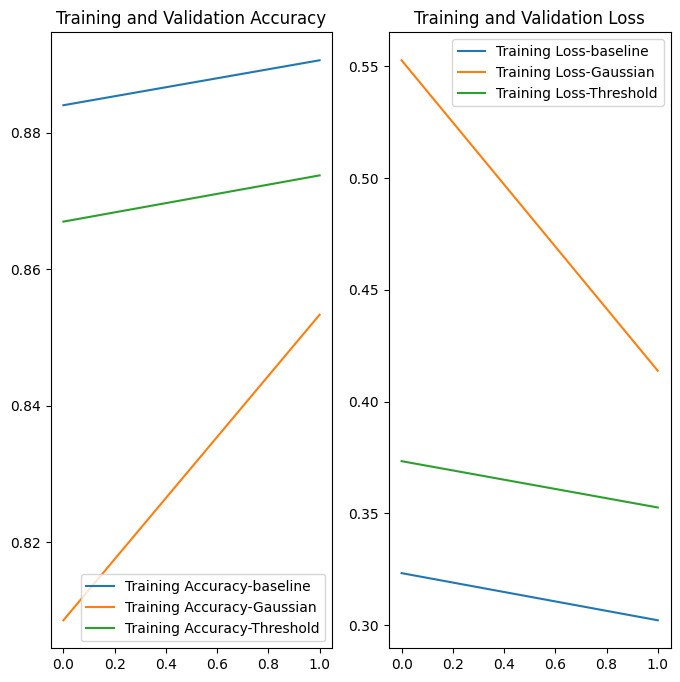

In [28]:
plt.figure(figsize=(8, 8))
visualization(empirical_history)
visualization(gaussian_history, "Gaussian")
visualization(threshold_history, "Threshold")
plt.show()
